# Assignment 2: Sentiment Classification Using Logistic Regression

## Programming Assignment (100 Points scaled to 40)

For this assignment we will be implementing a naive bayes baseline classifier. Additionally, we will be using pytorch to implement a binary logistic regression classifier. Our task is sentiment classification for hotel reviews. The input to your model will be a text review, and the output label is a 1 or 0 marking it as positive or negative.

We have provided a util.py file for loading the data, and some of the basic modeling. Your task is to fill in the functions below in order to train as accurate a classifier as possible!

We suggest browsing the util.py script first. Additionally, make sure to install dependencies from the provided requirements.txt file in a similar fashion to the pytorch tutorial. With your environment activated int he terminal, run:
```
pip install -r requirements.txt
```

In [1]:
from typing import List
import spacy
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import math
from tqdm.autonotebook import tqdm

/var/folders/8l/21c6qx3d1kx_wxpsc0n2_qdw0000gn/T/ipykernel_7621/3073619413.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Section 1: Sentiment Classification Dataset (Total: 20 Points)

The training data for this task consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [2]:
from util import load_train_data
pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Lets look at what is in the data

In [3]:
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
This hotel was a very nice and affordable stay. The beds were comfortable and it had cable. The shower worked great, and the continental breakfast included a nice variety of foods. I would definitely stay here again.

--- Negative Example ---
We stayed at the Days in on 39th in Brooklyn for about 5 days in December. My daughter needed to find a place to live and register for school. This was the cheapest hotel we could find in Brooklyn. We thought it would be really bad but it was actually worse. There were bed bugs and we brought them home with us. eeeeeek! The staff were very helpful when we needed to get a cab. There was a free buffet breakfast. It was edible and the coffee was great. For the money it would have been fine but getting rid of the bed bugs was a nightmare.


### Test Data ( WAIT TILL DEADLINE)

This is the test dataset that you will need to use to report the results on. This set is the unseen dataset meaning, you are not in anyway supoose to look what is in this dataset. We will release this dataset on the last day of the assignment's deadline.

In [4]:
# ### RUN THIS ONLY ON DEADLINE ###
# # Load the test data

# from util import load_test_data

# # FIXME
# test_datapath = "data/test-dataset.txt"
# test_texts, test_labels = load_train_data(test_datapath)

from typing import List, Tuple, Any


def load_test_data(filepath: str) -> Tuple[List[Any], List[Any]]:
    """Load the test data, producing a List of texts, labels

    Args:
        filepath (str): Path to the training file

    Returns:
        Tuple[List[Any], List[Any]]: The texts and labels
    """
    lab_map = {'POS': 1, 'NEG': 0}
    texts = []
    labels = []
    with open(filepath, "r") as file:
        for line in file:
            idx, text, label = line.rstrip().split("\t")
            texts.append(text)
            labels.append(lab_map[label])

    return texts, labels


test_texts, test_labels = load_test_data('./data/HW2-testset.txt')

### Task 1.1: Print the number of "positive" and "negative" samples (5 Points)

It is important to know the distribution of the training examples. More often than not, you will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

In [6]:
### ENTER CODE HERE ###

# Note since we have them in two seperate files, 
# this can also be done with bash commands

def label_distribution(labels):
    c = Counter(labels)
    v = list(c.values())
    k = list(c.keys())
    colors = sns.color_palette('pastel')
    plt.pie(v, labels= k, colors = colors, autopct='%.0f%%')
    plt.show();
    print(c)


### Task 1.2: Split Training and Development Sets (5 Points)

For the purpose of coming with the best parameters for the model you will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

Train Label Distribution:


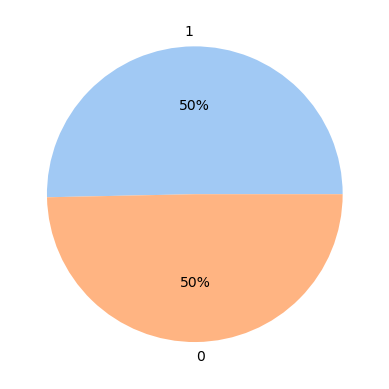

Counter({1: 76, 0: 75})
Dev Label Distribution:


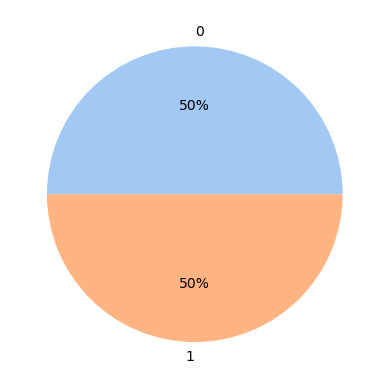

Counter({0: 19, 1: 19})


In [7]:
### ENTER CODE HERE ###

def split_dataset(texts, labels):
    """
    Split the dataset randomly into 80% training and 20% development set
    Make sure the splits have the same label distribution
    """
    z = zip(texts, labels)
    df = pd.DataFrame(z, columns=['review', 'label'])
    X = df['review']
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
    return list(X_train), list(y_train), list(X_test), list(y_test)
    
train_texts, train_labels, dev_texts, dev_labels = split_dataset(all_texts, all_labels)

print('Train Label Distribution:')
label_distribution(train_labels)

print('Dev Label Distribution:')
label_distribution(dev_labels)

### Task 1.3: Evaluation Metrics (10 Points)

Implement the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [8]:
### ENTER CODE HERE ###

def accuracy(predicted_labels, true_labels):
    
    """
    Accuracy is correct predictions / all predicitons
    """
    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    tn = np.sum((true_labels == 0) & (predicted_labels == 0))
    fn = np.sum((true_labels == 1) & (predicted_labels == 0))
    fp = np.sum((true_labels == 0) & (predicted_labels == 1))
    denom = (tp + tn + fn + fp) 
    return (tp + tn) / denom if denom != 0 else 0.0

def precision(predicted_labels, true_labels):
    """
    Precision is True Positives / All Positives Predictions
    """
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    fp = np.sum((true_labels == 0) & (predicted_labels == 1))
    
    denom = (tp + fp) 
    return tp / denom if denom != 0 else 0.0
    

def recall(predicted_labels, true_labels):
    """
    Recall is True Positives / All Positive Labels
    """
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    fn = np.sum((true_labels == 1) & (predicted_labels == 0))
    
    denom = (tp + fn) 
    return tp / denom if denom != 0 else 0.0

def f1_score(predicted_labels, true_labels):
    """
    F1 score is the harmonic mean of precision and recall
    """
    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    fn = np.sum((true_labels == 1) & (predicted_labels == 0))
    fp = np.sum((true_labels == 0) & (predicted_labels == 1))
    
    
    prec = precision(true_labels, predicted_labels)
    rec = recall(true_labels, predicted_labels)
    denom = (prec + rec)
    
    return  2 * (prec * rec ) /  denom if denom != 0 else 0.0

In [9]:
### DO NOT EDIT ###

em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3

assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Baselines (Total: 20 Points)

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model. You will create two baselines:

1. Random Chance
2. Naive Bayes Classifier

### Task 2.1: Random Chance Classifier (5 Points)

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [10]:
### ENTER CODE HERE ###

def predict_random(train_labels, num_samples) -> List[int]:
    """
    Using the label distribution, predict the label num_sample number of times
    """
    POSITIVE_LABEL = 1
    NEGATIVE_LABEL = 0
    label_count = Counter(train_labels)
    p1 = label_count[POSITIVE_LABEL] / len(train_labels)
    p0 = label_count[NEGATIVE_LABEL] / len(train_labels)
    print(f"p1 = {round(p1 * 100,2)}% p0 = {round(p0 * 100,2)}%")
    y_hat = []
    for _ in range(num_samples):
        num = random.random()
        if num < p1:
            y_hat.append(POSITIVE_LABEL)
        else:
            y_hat.append(NEGATIVE_LABEL)
    return y_hat
    
predict_random(train_labels, 10)

p1 = 50.33% p0 = 49.67%


[1, 1, 1, 0, 0, 0, 0, 1, 0, 1]

### Task 2.2: Naive Bayes Classifier (Total: 10 Points)

In the class, Jim went over how to implement a Naive Bayes Classifier using the tokens in the training samples.
In this task, you will do the same. As a preprocessing step, you might want to remove the stop words and lemmatize/stem the words of the texts. 

### Spacy Model https://spacy.io

To tokenize the text and help extract features from text, we will use the popular spaCy model

In [11]:
### DO NOT EDIT ###

# Initialize the spacy model
nlp = spacy.load('en_core_web_sm')

### Task 2.2.1: Play around with spacy (0 Points)

In [12]:
### ENTER CODE HERE ###

test_string = "This is an amazing sentence"

# parse the string with spacy model
test_doc = nlp(test_string)
print('Token', 'Lemma', 'Is_Stopword?\n')
for token in test_doc:
    print(token, token.lemma_, token.is_stop)

Token Lemma Is_Stopword?

This this True
is be True
an an True
amazing amazing False
sentence sentence False


### Task 2.2.2: Preprocessing (5 Points)

Remove stopwords and lemmatize the words of a text

In [13]:
### ENTER CODE HERE ###

def pre_process(text: str) -> List[str]:
    """
    remove stopwords and lemmatize and return an array of lemmas
    """
    doc = nlp(text)
    filtered_words = []
    for token in doc:
        if token.is_stop != True:
            filtered_words.append(token.lemma_)
            
    return filtered_words
    
test_string = "This sentence needs to be lemmatized"

assert len({'sentence', 'need', 'lemmatize', 'lemmatiz'}.intersection(pre_process(test_string))) >= 3

print('All Test Cases Passed!')

All Test Cases Passed!


### Task 2.2.3: The Naive Bayes Class (5 Points)

The standard way of implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [33]:
### ENTER CODE HERE ###


class NaiveBayesClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.label_word_counter = {}
        self.label_words_count = {}
    
    def fit(self, texts, labels):
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        POSITIVE_LABEL = 1
        NEGATIVE_LABEL = 0
        pos_samples = [text for text, label in zip(texts,labels) if label == POSITIVE_LABEL]
        neg_samples = [text for text, label in zip(texts, labels) if label == NEGATIVE_LABEL]
        filtered_pos_samples = pre_process(" ".join(pos_samples))
        filtered_neg_samples = pre_process(" ".join(neg_samples))
        pos_counter = dict(Counter(filtered_pos_samples))
        neg_counter = dict(Counter(filtered_neg_samples))
        
        
        self.label_word_counter[POSITIVE_LABEL] = pos_counter
        self.label_word_counter[NEGATIVE_LABEL] = neg_counter
        self.label_words_count[POSITIVE_LABEL] = len(filtered_pos_samples)
        self.label_words_count[NEGATIVE_LABEL] = len(filtered_neg_samples)
        
        
    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        filtered_texts = [pre_process(text) for text in texts]
        predictions = []

        for text in filtered_texts:
            log_probs = {}

            for label, word_count in self.label_words_count.items():
                log_prob = 0.0

                for word in text:
                    #calculate log prob of the word for the current class
                    word_count_in_class = self.label_word_counter[label].get(word, 0)
                    word_prob = (word_count_in_class + 1) / (word_count + len(self.label_word_counter[label]))

                    # add the log prob of the word to the current class's log prob
                    log_prob += math.log(word_prob)

                # calculate the final log prob for the current class
                log_prob += math.log(self.label_words_count[label] / sum(self.label_words_count.values()))

                # store the log probfor the current class
                log_probs[label] = log_prob

            #find the argmax 
            pred_label = max(log_probs, key=log_probs.get)
            predictions.append(pred_label)

        return predictions
        

### Task 2.3: Baseline Results  (5 Points)

Since there is not hyperparameter-tuing required for the baselines, we can use the entirety of the training set (no need to split the dataset into train and development). Report the results you achieve with the two baselines by running the following cell:

In [34]:
### DO NOT EDIT ###

### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(dev_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, dev_labels))

p1 = 50.33% p0 = 49.67%
Random Chance F1: 0.5
Naive Bayes F1: 0.9473684210526315


In [16]:
# ### DO NOT EDIT ###
# ### RUN THIS ONLY ON DEADLINE ###
# ### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

p1 = 50.26% p0 = 49.74%
Random Chance F1: 0.41860465116279066
Naive Bayes F1: 0.9056603773584904


## Section 3: Logistic Regression on Features (Total: 60 Points)

Now let's try building a logistic regression based classifier on hand-engineered features.

The following tasks are going to be the implementation of the components required in building a Logistic Regressor.

### Task 3.0: Feature Extraction (20 points)

This is perhaps the most challenging part of this assignment. In the class, we went over how to featurize text for a classification system for sentiment analysis. In this assignment, you should implement and build upon this to accuractely classify the hotel reviews.

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". Please go through some of the datapoints and convert the signals that you think might help in identifying "sentiment" as features.

Please refer to the section in Jim's book that illustrates the process of feature engineering for this task. We have attached an image of the table below:

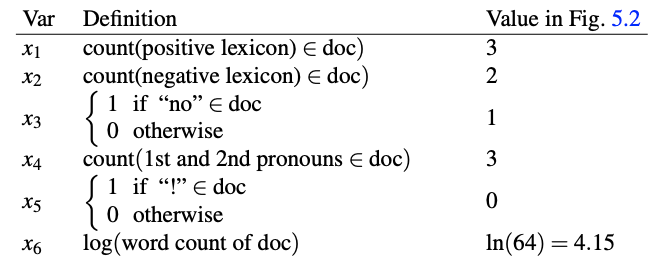

Please use the files with postive and negative words attached in the assignment: [positive_words.txt](data/poisitive-words.txt) and  [negative_words.txt](data/negative-words.txt)

In [17]:
pos_path = "data/positive-words.txt"
neg_path = "data/negative-words.txt"
pos_words, neg_words = [], []

with open(pos_path, "r") as f:
    for line in f:
        pos_words.append(line.strip())
with open(neg_path, "r") as f2:
    for line in f2:
        neg_words.append(line.strip())
        

In [18]:
def make_test_feature(text: spacy.tokens.doc.Doc):
    return "happy" in [t.lemma_ for t in text]


def extract_features(text: nlp):
    features = []
    # TODO: Replace this with your own feature extraction functions.
    p_count = 0 #x1
    n_count = 0 #x2
    is_no = 0 #x3
    pn_count = 0 #x4
    is_exc = 0 #x5
    is_cap = 0
    word_count = math.log(len(text)) #x6
    
    
    for token in text:
        if token.text.lower() in pos_words:
            p_count += 1
        if token.text.lower() in neg_words:
            n_count +=1
        if token.text == 'no':
            is_no = 1
        if token.pos_ == "PRON":
            pn_count += 1
        if token.text.isupper():
            is_cap = 1
        if text.text == "!":
            is_exc = 1
    
    features.extend([p_count, n_count, is_no, is_exc, word_count])
    
    return features

In [19]:
### ENTER CODE HERE ###
### DO NOT CHANGE THE SIGNATURE OF THE function THOUGH ###

def featurize_data(texts, labels):
    features = [
        extract_features(doc) for doc in nlp.pipe(texts)
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

### Task 3.0.2: Feature Scaling (10 Points)

In this task we will use the data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we need to call the following function before passing it to the classifier

#### Normalization Formula

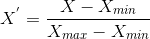

In [20]:
### ENTER CODE HERE ###
def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
    normalized_features = torch.empty_like(features, dtype=torch.float32)
    for i in range(features.size(0)):
        max_num = torch.max(features[i])
        min_num = torch.min(features[i])
        
        for j in range(features.size(1)):
            xi = features[i][j]
            norm = (xi - min_num) / (max_num - min_num)
            normalized_features[i][j] = norm
            
    return normalized_features


## Training a Logistic Regression Classifier (Total: 30 Points)

In this section, you will implement the components needed to train the binary classifier using logistic regression

### Here we define our pytorch logistic regression classifier (DO NOT EDIT THIS)

In [21]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)

        # Initialize weights. Note that this is not strictly necessary,
        # but you should test different initializations per lecture
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # We predict a number by multipling by the coefficients
        # and then take the sigmoid to turn the score as logits
        return torch.sigmoid(self.coefficients(features))

### Task 3.1: Initialize the weights. (5 Points)

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we need to try different initialization methods and compare the accuracy we achieve for the development set. In this task, implement the function that initializes the parameters to ...

In [22]:
### ENTER CODE HERE ###

def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """

    torch.nn.init.zeros_(coefficients.weight)

    print(coefficients.weight.data)


Let's build a training function similar to the linear regressor from the tutorial

### Task 3.2: Logistic Loss Function (10 Points)

In [23]:
### ENTER CODE HERE ###

def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """
    loss = torch.mean(- ((label * torch.log(prediction)) + (1 - label) * torch.log(1 - prediction)) )
    # print("loss", loss)
    return loss
    
    

### Task 3.3: Create an SGD optimizer (0 Points)

We have already provided the implementation of how to create the SGD optimizer

You may try different optimizers refering to the docs provided

In [24]:
### ENTER CODE HERE ###

def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

### Task 3.5: Converting Logits into Predictions (5 Points)

In [25]:
### ENTER CODE HERE ###

def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)

        prediction = (logits >= 0.5).float()

        p = prediction.squeeze(-1)
        return p

### Training Function (DO NOT EDIT THIS)

In [26]:
### DO NOT EDIT ###

from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model, dev_features), dev_labels)
        acc = accuracy(predict(model, dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

### Task 3.6: Train the classifier (10 Points)

Run the following cell to train a logistic regressor on your hand-engineered features.

In [27]:
### DO NOT EDIT ###

num_epochs = 100

train_features, train_labels_tensor = featurize_data(train_texts, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_texts, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.01)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

tensor([[0., 0., 0., 0., 0.]])
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0, loss: 0.6927207827568054
Dev F1 0.0


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1, loss: 0.6888343155384063
Dev F1 0.0


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2, loss: 0.6850044190883636
Dev F1 0.5384615384615384


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3, loss: 0.6812292039394379
Dev F1 0.8823529411764706


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4, loss: 0.6775069117546082
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5, loss: 0.6738358855247497
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6, loss: 0.6702146351337432
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7, loss: 0.6666417837142944
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8, loss: 0.6631160259246827
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9, loss: 0.6596361696720123
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10, loss: 0.6562010705471039
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11, loss: 0.6528097212314605
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12, loss: 0.6494610548019409
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13, loss: 0.646154248714447
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14, loss: 0.6428883314132691
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15, loss: 0.6396625638008118
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16, loss: 0.6364760816097259
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17, loss: 0.6333282232284546
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18, loss: 0.630218243598938
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19, loss: 0.6271454215049743
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20, loss: 0.6241091609001159
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21, loss: 0.621108877658844
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22, loss: 0.6181438982486724
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23, loss: 0.6152136862277985
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24, loss: 0.61231769323349
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25, loss: 0.6094553768634796
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26, loss: 0.6066262006759644
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27, loss: 0.6038296818733215
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28, loss: 0.6010653257369996
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29, loss: 0.5983326733112335
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30, loss: 0.595631194114685
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 31, loss: 0.5929605066776276
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32, loss: 0.5903201460838318
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 33, loss: 0.5877096772193908
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34, loss: 0.5851286709308624
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 35, loss: 0.5825767397880555
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36, loss: 0.5800534546375274
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 37, loss: 0.5775584518909455
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38, loss: 0.5750912427902222
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 39, loss: 0.5726515889167786
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40, loss: 0.5702390432357788
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 41, loss: 0.5678531944751739
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42, loss: 0.5654937207698822
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 43, loss: 0.5631602823734283
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44, loss: 0.5608524918556214
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 45, loss: 0.5585700035095215
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46, loss: 0.556312519311905
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 47, loss: 0.554079657793045
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 48, loss: 0.5518710851669312
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 49, loss: 0.5496865689754487
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 50, loss: 0.5475256979465485
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 51, loss: 0.5453882038593292
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 52, loss: 0.5432737410068512
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 53, loss: 0.541182005405426
Dev F1 0.9473684210526315


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 54, loss: 0.5391126811504364
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 55, loss: 0.5370655626058578
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 56, loss: 0.5350402414798736
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 57, loss: 0.5330365061759949
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 58, loss: 0.5310539990663529
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 59, loss: 0.5290925025939941
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 60, loss: 0.5271517395973205
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 61, loss: 0.5252314209938049
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 62, loss: 0.523331242799759
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 63, loss: 0.5214510381221771
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 64, loss: 0.5195904612541199
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 65, loss: 0.5177492588758469
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 66, loss: 0.5159272104501724
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 67, loss: 0.514124071598053
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 68, loss: 0.5123395681381225
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 69, loss: 0.510573434829712
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 70, loss: 0.5088254779577255
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 71, loss: 0.5070954620838165
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 72, loss: 0.5053831309080123
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 73, loss: 0.5036882638931275
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 74, loss: 0.5020106375217438
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 75, loss: 0.5003500491380691
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 76, loss: 0.4987062007188797
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 77, loss: 0.4970789611339569
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 78, loss: 0.49546812772750853
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 79, loss: 0.4938734173774719
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 80, loss: 0.49229462444782257
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 81, loss: 0.49073159098625185
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 82, loss: 0.4891841173171997
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 83, loss: 0.48765195310115816
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 84, loss: 0.4861349523067474
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 85, loss: 0.4846329212188721
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 86, loss: 0.4831456273794174
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 87, loss: 0.481672927737236
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 88, loss: 0.48021461963653567
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 89, loss: 0.47877052128314973
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 90, loss: 0.47734046578407285
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 91, loss: 0.47592424154281615
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 92, loss: 0.47452170252799986
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 93, loss: 0.4731326550245285
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 94, loss: 0.4717570036649704
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 95, loss: 0.4703944712877274
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 96, loss: 0.4690449833869934
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 97, loss: 0.46770833134651185
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 98, loss: 0.4663843274116516
Dev F1 0.972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 99, loss: 0.4650728672742844
Dev F1 0.972972972972973


### Task 3.7: Get the predictions on the Test Set using the Trained model and print the F1 score (10 Points)

In [28]:
### DO NOT EDIT ###
### DEV SET RESULTS

test_features, test_labels = featurize_data(dev_texts, dev_labels)
test_features = normalize(test_features)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

Logistic Regression Results:
Accuracy: 0.9736842105263158
F1-score 0.972972972972973


In [29]:
test_texts, test_labels = load_test_data('./data/HW2-testset.txt')

In [30]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

test_features, test_labels = featurize_data(test_texts, test_labels)
test_features = normalize(test_features)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

Logistic Regression Results:
Accuracy: 0.92
F1-score 0.923076923076923


## Written Assignment (60 Points)

Written assignment tests the understanding of the student for the assignment's task. We have split the writing into sections. You will need to write 1-2 paragraphs describing the sections. Please be concise.

### In your own words, describe what the task is (20 points)

The task of Section 3 was to create a logistic regression machine learning model that can accurately predict the sentiment of a user review. This is achieved by transforming text reviews into numerical features, such as the frequency of positive or negative words. Once the features are converted, I can train a logistic regression model to predict positive or negative sentiment. This is accomplished by taking the weighted sum of the features and passing it through a logistic function, which outputs a probability between 0 and 1. A score of 0 is classified as a bad review, and 1 is classified as good.

### Describe your method for the task (10 points)

The two main methods I used for tuning my model were choosing the weights and features. Feature extraction was interesting because I tried adding additional features to the example given, and at times, it made the results worse. As I experimented with weights and the number of features, I found that the pronoun count actually degraded the model's performance. I eventually settled on using only the positive and negative word count, the presence of "no" as a boolean, the presence of an exclamation mark as a boolean, and the total word count.

 I experimented with using all zero initial weights, a Xavier normal distribution of weights, and the Xavier uniform distribution of weights. When I used the normal and uniform distribution of weights, I didn't get consistent scores from my model. Sometimes they were excellent with a 90%+ F1 score, and other times they hovered around 50%. However, when I set the initial weights to zero, my model consistently performed in the high 95%-97%+ range. Thus, I decided to stick with that implementation.

### Experiment Results (10 points)

Experiments:

1

Initial weights = 0

Normal example features

Accuracy = 92%

F1 = 91%

2

Initial weights = 0

Normal features + all caps word count

Accuracy = 97%

F1 = 97%

3

Initial weights = 0

Normal features minus pronouns

Accuracy = 97%

F1 = 97%

4

Initial weights = 0

Normal features + all caps word count + is happy

Accuracy = 94%

F1 = 94%

5

Initial weights = 0

Normal features + all caps word count + pro noun count

Accuracy = 86%

F1 = 85%

6

Initial weights = 0

Normal features + pro noun count

Accuracy = 92%

F1 = 91%

7

Initial weights = [ 0.0728,  1.4829,  0.3499,  0.3161, -0.6577,  0.0807]

Normal features 

Accuracy: 60%

F1-score: 50%

### Discussion (20 points)

Key takeaway from the assignment. Why is the method good? shortcomings? how would you improve? Additional thoughts?

This was a fun assignment. Some of my key takeaways were how important the starting feature weights were to the overall performance of the model. In this particular instance, when the weights were pseudo random each time, the model could end up with a very low or very high F1 score. When I started with weights that were all zero, the score was much more consistent across each trial and was higher, which was interesting to see. I probably could have spent more time on the feature engineering part, but the project was already quite time consuming, so I opted for some minor feature engineering. Another interesting aspect was that I ended up reducing the feature size to a smaller set than what was provided in the examples. This produced a better overall score and, I suppose, reduced the complexity of the model.

To improve the model, I bet if we implemented tf-idf, it would enhance the overall performance.